In [2]:
using Distributed
procs_to_use = 12
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [38]:
@everywhere using QuantumStates, OpticalBlochEquations, DifferentialEquations, UnitsToValue, StructArrays, StaticArrays, Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter, Plots
;

In [39]:
@everywhere include("helper_functions.jl")
include("define_molecular_structure.jl")
include("define_sim_params.jl")
include("define_prob.jl")
include("compute_size_temperature.jl")
;

In [46]:
using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

prob_func!(prob)
@time sol = DifferentialEquations.solve(prob, progress=true, progress_steps=100000, save_everystep=false, saveat=[])
# @time sol = DifferentialEquations.solve(prob, save_everystep=false, saveat=[])
;

ODE   0%|█                                              |  ETA: N/A
ODE   5%|███                                            |  ETA: 0:00:24
ODE  11%|██████                                         |  ETA: 0:00:13
ODE  17%|████████                                       |  ETA: 0:00:09
ODE  23%|███████████                                    |  ETA: 0:00:07
ODE  28%|██████████████                                 |  ETA: 0:00:06
ODE  34%|████████████████                               |  ETA: 0:00:05
ODE  39%|███████████████████                            |  ETA: 0:00:04
ODE  45%|██████████████████████                         |  ETA: 0:00:04
ODE  51%|█████████████████████████                      |  ETA: 0:00:03
ODE  57%|███████████████████████████                    |  ETA: 0:00:03
ODE  63%|██████████████████████████████                 |  ETA: 0:00:02
ODE  69%|█████████████████████████████████              |  ETA: 0:00:02
ODE  74%|███████████████████████████████████            |  ETA: 0:00

  6.928859 seconds (5.36 M allocations: 266.690 MiB, 0.77% gc time, 42.56% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:05


In [ ]:
prob.p.add_spontaneous_decay_kick = true
n_trajectories = 10
sols = distributed_solve(n_trajectories, prob, prob_func!, scan_nothing, [0])
;

Progress:  69%|█████████████████████████████            |  ETA: 0:00:27

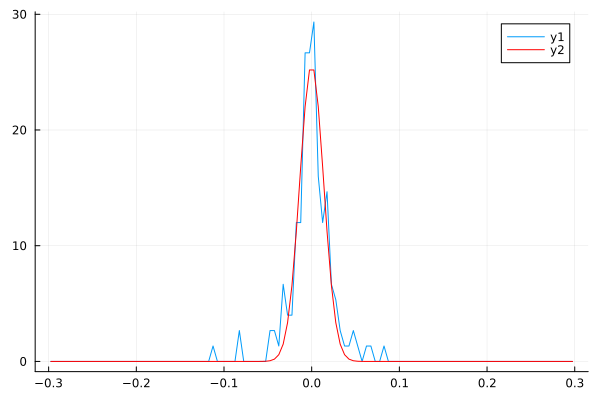

In [17]:
i = 120
vxs = [vx(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vxs, -0.3:0.005:0.3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann_1D, v, fv, [1, 0.1e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann_1D(v, v_fit.param), color=:red)

1.5752007038842166

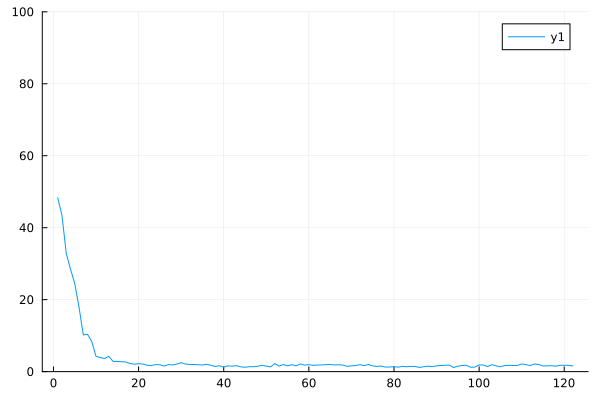

In [18]:
Ts = T_vs_time(sols[1])
display(Ts[end] .* 1e6)
plot(Ts .* 1e6, ylim=(0,100))

# Include diffusion

In [292]:
prob_func!(prob_periodic)
@time sol = DifferentialEquations.solve(prob_periodic, progress=true, progress_steps=100000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   4%|███                                            |  ETA: 0:00:19
ODE   9%|█████                                          |  ETA: 0:00:18
ODE  14%|███████                                        |  ETA: 0:00:13
ODE  19%|██████████                                     |  ETA: 0:00:11
ODE  25%|████████████                                   |  ETA: 0:00:09
ODE  30%|██████████████                                 |  ETA: 0:00:08
ODE  35%|█████████████████                              |  ETA: 0:00:07
ODE  40%|███████████████████                            |  ETA: 0:00:07
ODE  45%|██████████████████████                         |  ETA: 0:00:06
ODE  50%|████████████████████████                       |  ETA: 0:00:05
ODE  55%|██████████████████████████                     |  ETA: 0:00:05
ODE  60%|█████████████████████████████                  |  ETA: 0:00:04
ODE  65%|███████████████████████████████                |  ETA: 0:00

  9.523319 seconds (25.80 M allocations: 4.067 GiB, 8.98% gc time, 9.45% compilation time: 99% of which was recompilation)



ODE 100%|███████████████████████████████████████████████| Time: 0:00:09


In [293]:
prob_periodic.p.diffusion_constant = [0.15, 0.15, 0.15]
n_trajectories = 20
sols = distributed_solve(n_trajectories, prob_periodic, prob_func!, scan_nothing, [0])
;

Progress: 100%|█████████████████████████████████████████| Time: 0:04:27


In [5]:
n_trajectories1 = 20
n_trajectories2 = 200
n_trajectories_diffusion = 5000
n_times = 10
diffusion_t_end = 10e-6
diffusion_τ_total = 10e-6
;

In [33]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:04
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18
Progress: 100%|█████████████████████████████████████████| Time: 0:03:27
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14
Progress: 100%|█████████████████████████████████████████| Time: 0:03:28


In [ ]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_periodic, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)

;

Progress:  32%|█████████████                            |  ETA: 0:02:24

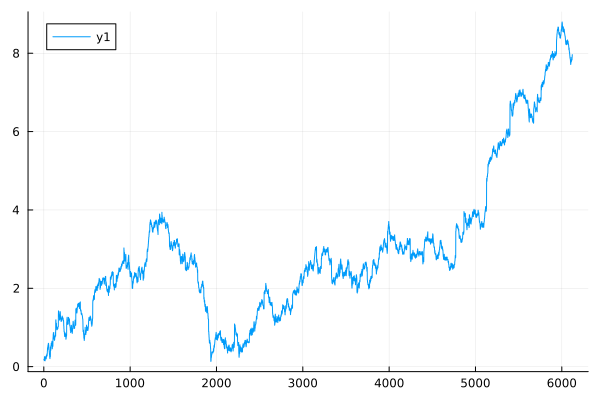

In [47]:
i = 10
sqrt.(vx.(sols_with_diffusion[i].u).^2 .+ vy.(sols_with_diffusion[i].u).^2 .+ vz.(sols_with_diffusion[i].u).^2) |> plot

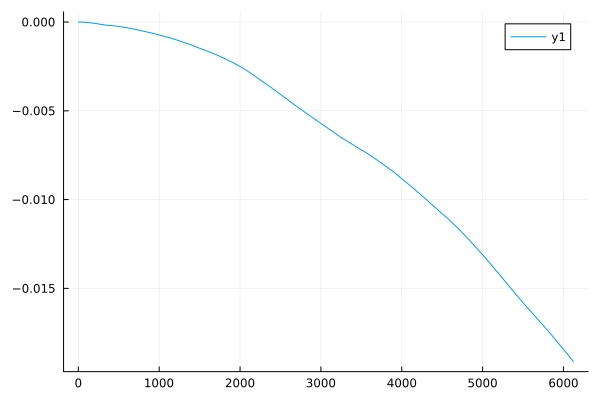

In [48]:
i = 6
z.(sols_with_diffusion[i].u) |> plot

In [49]:
Ts = T_vs_time(sols_no_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6, ylim=(0,50))

Ts = T_vs_time(sols_with_diffusion)
display(Ts[end] .* 1e6)
plot!(Ts .* 1e6, ylim=(0,100))

1.698971483476733

LoadError: DomainError with -11.860683043322437:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

In [50]:
diffusion_error

0.06359826852177342

In [51]:
diffusion

0.24301906649869986

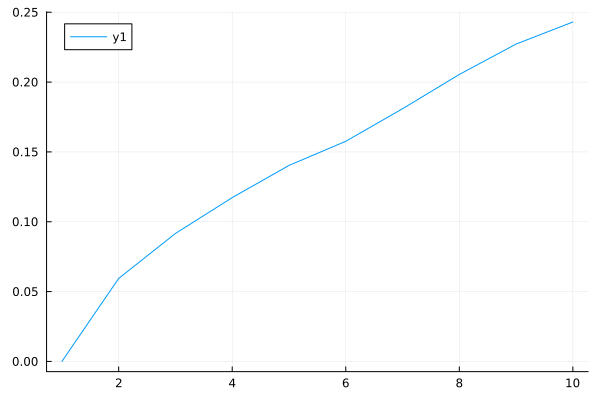

In [52]:
plot(diffusion_over_time)

In [53]:
Ts = T_vs_time(sols_with_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6, ylim=(0,100))

LoadError: DomainError with -11.860683043322437:
Exponentiation yielding a complex result requires a complex argument.
Replace x^y with (x+0im)^y, Complex(x)^y, or similar.

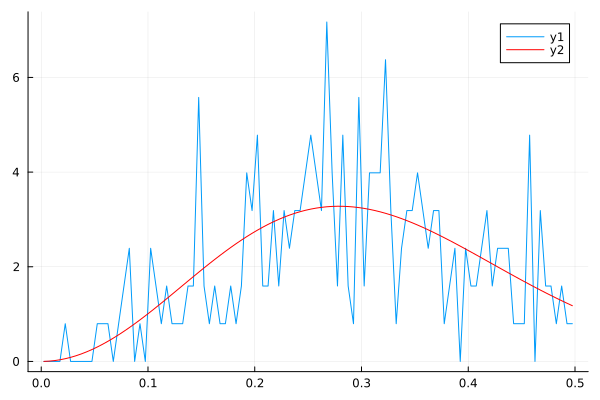

In [311]:
i = 400
vxs = [vx(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols[1] if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vs, 0:0.005:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [1, 5e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann(v, v_fit.param), color=:red)

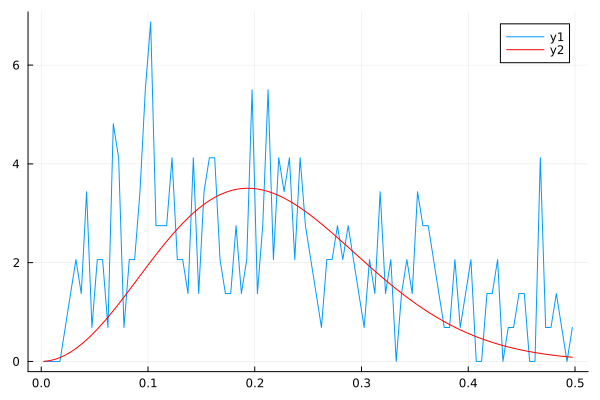

In [288]:
i = 2
vxs = [vx(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vs, 0:0.005:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [1, 5e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann(v, v_fit.param), color=:red)

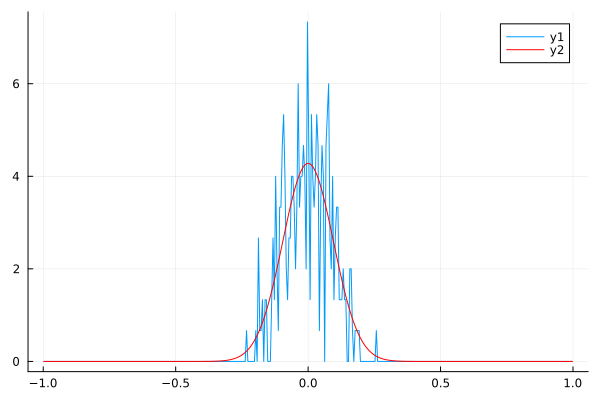

In [127]:
i = 1
vxs = [vx(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vys = [vy(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vzs = [vz(sol.u[i]) for sol ∈ sols_with_diffusion if survived(sol,i)]
vs = sqrt.(vxs.^2 .+ vys.^2 .+ vzs.^2)

hist_data = fit(Histogram, vxs, -1:0.005:1)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(maxwell_boltzmann_1D, v, fv, [1, 0.1e-6], autodiff=:forward)
A, temp = v_fit.param

plot(v, fv)
plot!(v, maxwell_boltzmann_1D(v, v_fit.param), color=:red)

In [7]:
prob_1plus2.p.sim_params.s_factor_start = 0.9
prob_1plus2.p.sim_params.s_factor_end = 0.7
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [8]:
# n_trajectories1 = 100
# n_trajectories2 = 500
# n_trajectories_diffusion = 100000
n_trajectories1 = 20
n_trajectories2 = 200
n_trajectories_diffusion = 50000
n_times = 10
diffusion_t_end = 10e-6
diffusion_τ_total = 10e-6
;

## (a)

In [9]:
prob_1plus2.p.sim_params.s_factor_start = 1.0
prob_1plus2.p.sim_params.s_factor_end = 1.0
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [10]:
# total_sats = (0.3:0.4:2.1) .* total_sat
total_sats = [0.7] .* total_sat
@everywhere function update_total_s!(prob, total_sat)
    prob.p.sim_params.total_sat = total_sat
    return nothing
end
; 

In [11]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_total_s!, total_sats
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [12]:
plot(diffusion_over_time)

LoadError: UndefVarError: `diffusion_over_time` not defined

In [13]:
σxs = σx_fit(sols_with_diffusion)
σys = σy_fit(sols_with_diffusion)
σzs = σz_fit(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(total_sats, σs, ylim=(40e-6, 140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [14]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(total_sats, Ts, ylim=(0, 700e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [15]:
Ts

LoadError: UndefVarError: `Ts` not defined

## (b)

In [16]:
detunings = [1.68, 3.16, 4.64, 6.12, 7.60, 9.08, 10.56, 12.04, 13.52, 15.00]
@everywhere function update_detuning!(prob, detuning)
    δ1 = +0.00
    δ2 = -1.00
    δ3 = +0.75
    Δ1 = 1e6 * (detuning + δ1) * (2π / Γ)
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[1] = prob.p.ω0s[end] - prob.p.ω0s[1] + Δ1
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
;

In [17]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_detuning!, detunings
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [18]:
plot(diffusion_over_time)

LoadError: UndefVarError: `diffusion_over_time` not defined

In [19]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(detunings, σs, ylim=(40e-6, 140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [20]:
σs

LoadError: UndefVarError: `σs` not defined

In [21]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(detunings, Ts, ylim=(0, 700e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [22]:
Ts

LoadError: UndefVarError: `Ts` not defined

## (c)

In [23]:
δIIas = collect(range(+0.25, -3.25, 15))
@everywhere function update_δIIa!(prob, δIIa)
    detuning = 7.6
    δ2 = δIIa
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    return nothing
end
; 

In [24]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIa!, δIIas
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [25]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIas, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6, 140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [26]:
σs

LoadError: UndefVarError: `σs` not defined

In [27]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIas, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [28]:
Ts

LoadError: UndefVarError: `Ts` not defined

## (d)

In [29]:
collect(δIIbs)

LoadError: UndefVarError: `δIIbs` not defined

In [30]:
# δIIbs = range(-0.75, 2.25, 15)
δIIbs = [2.25]
@everywhere function update_δIIb!(prob, δIIb)
    detuning = 7.6
    δ3 = δIIb
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
; 

In [31]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIb!, δIIbs
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [32]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIbs, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6,140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [33]:
σs

LoadError: UndefVarError: `σs` not defined

In [34]:
Txs = Tx_fit(sols_with_diffusion)
Tys = Ty_fit(sols_with_diffusion)
Tzs = Tz_fit(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIbs, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [35]:
Ts

LoadError: UndefVarError: `Ts` not defined

## (e)

In [36]:
B_div_C = 0.37/0.28
A_div_BC = [0, 0.37, 1.25, 2.60, 4.5, 7.0, 9.6, 12.6, 15.0, 18.3, 20.9, 22.9]
A_div_BC = A_div_BC ./ (31.4 .- A_div_BC)
A_div_C = A_div_BC .* (1 .+ B_div_C)
C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
A_div_ABC = A_div_C .* C_div_ABC
B_div_ABC = B_div_C .* C_div_ABC
;

In [37]:
# all_params = [1300]
# B_div_C = 0.37/0.28
# A_div_C = (1.2 .* all_params / 1100)
# C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
# A_div_ABC = A_div_C .* C_div_ABC
# B_div_ABC = B_div_C .* C_div_ABC
# ;

In [38]:
# Calculate the saturation parameters for IIa and IIb for a range of saturation ratios
sat_ratios = zip(B_div_ABC, C_div_ABC, A_div_ABC)

@everywhere function update_sat_ratios!(prob, sat_ratios)
    I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = sat_ratios
    prob.p.sim_params.s1_ratio = I_sat_ratio
    prob.p.sim_params.s2_ratio = IIa_sat_ratio
    prob.p.sim_params.s3_ratio = IIb_sat_ratio
    return nothing
end

# II_total_sat = sats[2] + sats[3]
# IIab_sats = zip(IIa_sat_ratios .* II_total_sat, IIb_sat_ratios .* II_total_sat)
; 

In [39]:
I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = first(sat_ratios)

(0.5692307692307692, 0.4307692307692308, 0.0)

In [40]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_sat_ratios!, sat_ratios
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [41]:
plot(diffusion_over_time)

LoadError: UndefVarError: `diffusion_over_time` not defined

In [42]:
σs

LoadError: UndefVarError: `σs` not defined

In [43]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot((σxs .* σys .* σzs) .^ (1/3), ylim=(0,140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [44]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot((Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined

In [45]:
Ts

LoadError: UndefVarError: `Ts` not defined

In [46]:
include("compute_size_temperature.jl")

In [47]:
prob_1plus2.p.sim_params.s_factor_start = 0.9
prob_1plus2.p.sim_params.s_factor_end = 0.7
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [48]:
# n_trajectories1 = 100
# n_trajectories2 = 500
# n_trajectories_diffusion = 100000
n_trajectories1 = 50
n_trajectories2 = 200
n_trajectories_diffusion = 50000
n_times = 10
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6
;

In [49]:
B_grads = [25] #25:25:175
@everywhere function update_B_grad!(prob, B_grad)
    prob.p.sim_params.B_grad_end = B_grad
    return nothing
end
; 

In [50]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_B_grad!, B_grads
)
;

LoadError: UndefVarError: `prob_1plus2` not defined

In [51]:
plot(diffusion_over_time)

LoadError: UndefVarError: `diffusion_over_time` not defined

In [52]:
σs

LoadError: UndefVarError: `σs` not defined

In [53]:
σxs = σx_fit(sols_with_diffusion)
σys = σy_fit(sols_with_diffusion)
σzs = σz_fit(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(B_grads, σs, ylim=(0e-6,140e-6))

LoadError: UndefVarError: `sols_with_diffusion` not defined